In [1]:
import numpy as np
import pandas as pd
import torch, copy, random, time, cv2, os
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from PIL import Image
from torchinfo import summary
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.models as models
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc, f1_score, accuracy_score
from sklearn.preprocessing import label_binarize
import seaborn as sns
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
from collections import defaultdict

In [2]:
# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

pd.set_option('future.no_silent_downcasting', True)

### Dataset Description

In [3]:
a2c_desc = pd.read_csv('A2C.csv')
a4c_desc = pd.read_csv('A4C.csv')

In [4]:
# Data to exclude
excluded_data = [
    "ES000130_4CH_1",
    "ES00026 _4CH_1",
]

# Exclude rows where 'ECHO' is in excluded_data
a2c_desc = a2c_desc[~a2c_desc["ECHO"].isin(excluded_data)]
a4c_desc = a4c_desc[~a4c_desc["ECHO"].isin(excluded_data)]

# Extract the number after 'ES000' using string operations
a2c_desc['Number'] = a2c_desc['ECHO'].str.extract(r'ES000(\d+)').astype(int)
a4c_desc['Number'] = a4c_desc['ECHO'].str.extract(r'ES000(\d+)').astype(int)

# Sort data by 'ECHO' columns in ascending order
a2c_desc = a2c_desc.sort_values(by='Number').reset_index(drop=True)
a4c_desc = a4c_desc.sort_values(by='Number').reset_index(drop=True)

In [5]:
a2c_desc.tail(5)

,ECHO,SEG4,SEG10,SEG15,SEG13,SEG7,SEG1,Reference Frame,End of Cycle,Number
155,ES000196 N_2CH_1,non-MI,non-MI,non-MI,non-MI,non-MI,non-MI,1,22,196
156,ES000197 N_2CH_1,non-MI,non-MI,non-MI,non-MI,non-MI,non-MI,2,19,197
157,ES000199 N_2CH_2,non-MI,non-MI,non-MI,non-MI,non-MI,non-MI,34,70,199
158,ES000200 N_2CH_2,non-MI,non-MI,non-MI,non-MI,non-MI,non-MI,1,24,200
159,ES000201 N_2CH_3,non-MI,non-MI,non-MI,non-MI,non-MI,non-MI,20,39,201


In [6]:
a4c_desc.tail(5)

,ECHO,SEG3,SEG9,SEG14,SEG16,SEG12,SEG6,match with A2C,Reference Frame,End of Cycle,Number
155,ES000196 n_4CH_1,non-MI,non-MI,non-MI,non-MI,non-MI,non-MI,NaN,1,26,196
156,ES000197 n_4CH_1,non-MI,MI,MI,non-MI,non-MI,non-MI,NaN,20,41,197
157,ES000199 n_4CH_1,non-MI,non-MI,non-MI,non-MI,non-MI,non-MI,NaN,1,25,199
158,ES000200 n_4CH_1,non-MI,non-MI,non-MI,non-MI,non-MI,non-MI,NaN,1,22,200
159,ES000201 n_4CH_1,non-MI,non-MI,MI,non-MI,non-MI,non-MI,NaN,1,24,201


In [7]:
print("List of dataset features/columns for A2C: ")
print(list(a2c_desc.columns))       # List of column names

List of dataset features/columns for A2C: 
['ECHO', 'SEG4', 'SEG10', 'SEG15', 'SEG13', 'SEG7', 'SEG1', 'Reference Frame', 'End of Cycle', 'Number']


In [8]:
print("List of dataset features/columns for A4C: ")
print(list(a4c_desc.columns))       # List of column names

List of dataset features/columns for A4C: 
['ECHO', 'SEG3', 'SEG9', 'SEG14', 'SEG16', 'SEG12', 'SEG6', 'match with A2C', 'Reference Frame', 'End of Cycle', 'Number']


In [9]:
print("The record number of hmc-qu video recording dataset:", a4c_desc.shape[0])

The record number of hmc-qu video recording dataset: 160


### Video Recording Examples

### Custom Video Recording Dataset

In [10]:
class HMC_QU_VideoDataset(Dataset):
    def __init__(self, a2c_csv_file, a2c_npy_dir, a4c_csv_file, a4c_npy_dir, size=(224, 224), transform=None, excluded_data=["ES000130", "ES00026"], device='cuda', grayscale=True):
        self.size = size
        self.transform = transform
        self.device = torch.device(device if torch.cuda.is_available() else 'cpu')
        self.grayscale = grayscale

        # Load CSV files and exclude specified data
        self.df = [pd.read_csv(a2c_csv_file), pd.read_csv(a4c_csv_file)]
        self.df[0] = self.df[0][~self.df[0]["ECHO"].str.startswith(tuple(excluded_data))]
        self.df[1] = self.df[1][~self.df[1]["ECHO"].str.startswith(tuple(excluded_data))]
        self.df[0]['Number'] = self.df[0]['ECHO'].str.extract(r'ES000(\d+)').astype(int)
        self.df[1]['Number'] = self.df[1]['ECHO'].str.extract(r'ES000(\d+)').astype(int)
        self.df[0] = self.df[0].sort_values(by='Number').reset_index(drop=True)
        self.df[1] = self.df[1].sort_values(by='Number').reset_index(drop=True)

        self.npy_dir = [a2c_npy_dir, a4c_npy_dir]
        self.video_files = [self.df[0]["ECHO"].values + '.npy', self.df[1]["ECHO"].values + '.npy']
        self.labels = [self.df[0].iloc[:, 1:7].replace({'MI': 1, 'non-MI': 0}).values.astype(np.float32),
                       self.df[1].iloc[:, 1:7].replace({'MI': 1, 'non-MI': 0}).values.astype(np.float32)]

        # Define default transform
        if self.transform is None:
            transforms_list = [transforms.ToPILImage()]
            if self.grayscale:
                transforms_list.append(transforms.Grayscale(num_output_channels=1))
            transforms_list.extend([
                transforms.CenterCrop(400),
                transforms.Resize(self.size),
                transforms.ToTensor()
            ])
            self.transform = transforms.Compose(transforms_list)

        # Preload and transform all videos (store on CPU)
        self.videos_a2c = []
        self.videos_a4c = []
        self.lengths_a2c = []
        self.lengths_a4c = []
        self.labels_a2c = []
        self.labels_a4c = []

        for idx in range(len(self.video_files[0])):
            video_path_a2c = self.npy_dir[0] + '/' + self.video_files[0][idx]
            video_path_a4c = self.npy_dir[1] + '/' + self.video_files[1][idx]
            video_a2c = np.load(video_path_a2c)  # (T, H, W, C), float32 or uint8
            video_a4c = np.load(video_path_a4c)  # (T, H, W, C)

            video_a2c_processed = []
            video_a4c_processed = []
            
            for frame in video_a2c:
                if frame.dtype != np.uint8:
                    # Scale float to [0, 1], then to [0, 255] for PIL
                    frame = (frame - frame.min()) / (frame.max() - frame.min() + 1e-8)  # Normalize to [0, 1]
                    frame = (frame * 255.0).clip(0, 255).astype(np.uint8)
                frame = self.transform(frame)  # (C, H, W), C=1 if grayscale, values [0, 1]
                video_a2c_processed.append(frame)
            
            for frame in video_a4c:
                if frame.dtype != np.uint8:
                    frame = (frame - frame.min()) / (frame.max() - frame.min() + 1e-8)
                    frame = (frame * 255.0).clip(0, 255).astype(np.uint8)
                frame = self.transform(frame)
                video_a4c_processed.append(frame)

            video_a2c = torch.stack(video_a2c_processed, dim=0)  # (T, C, H, W), CPU
            video_a4c = torch.stack(video_a4c_processed, dim=0)  # (T, C, H, W), CPU

            self.videos_a2c.append(video_a2c)
            self.videos_a4c.append(video_a4c)
            self.lengths_a2c.append(video_a2c.shape[0])
            self.lengths_a4c.append(video_a4c.shape[0])
            self.labels_a2c.append(torch.tensor(self.labels[0][idx]))
            self.labels_a4c.append(torch.tensor(self.labels[1][idx]))

    def __len__(self):
        return len(self.videos_a2c)

    def __getitem__(self, idx):
        # Move to GPU during access
        video_a2c = self.videos_a2c[idx].to(self.device)
        len_a2c = self.lengths_a2c[idx]
        video_a4c = self.videos_a4c[idx].to(self.device)
        len_a4c = self.lengths_a4c[idx]
        label_a2c = self.labels_a2c[idx].to(self.device)
        label_a4c = self.labels_a4c[idx].to(self.device)

        return video_a2c, len_a2c, video_a4c, len_a4c, label_a2c, label_a4c

In [11]:
hmc_qu_dataset = HMC_QU_VideoDataset("A2C.csv", "./npy_videos/A2C", "A4C.csv", "./npy_videos/A4C", size=(224,224), grayscale = True)

In [12]:
total_size = len(hmc_qu_dataset)

train_size = int(0.7 * total_size)
val_size   = int(0.15 * total_size)
test_size  = total_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    hmc_qu_dataset, [train_size, val_size, test_size]
)

In [13]:
def collate_fn(batch):
    videos_a2c, lengths_a2c, videos_a4c, lengths_a4c, labels_a2c, labels_a4c = zip(*batch)

    # Pad sequences
    videos_a2c = nn.utils.rnn.pad_sequence(videos_a2c, batch_first=True)  # (B, T_max, C, H, W)
    videos_a4c = nn.utils.rnn.pad_sequence(videos_a4c, batch_first=True)

    lengths_a2c = torch.tensor(lengths_a2c)
    lengths_a4c = torch.tensor(lengths_a4c)

    labels_a2c = torch.stack(labels_a2c)
    labels_a4c = torch.stack(labels_a4c)

    return videos_a2c, lengths_a2c, videos_a4c, lengths_a4c, labels_a2c, labels_a4c

In [14]:
# Configure batch size and num of workers
batch_size = 4
num_workers = 0

# Create DataLoader for the training, validation and testing dataset
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True, num_workers = num_workers, collate_fn=collate_fn)
valid_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle=False, num_workers = num_workers, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False, num_workers = num_workers, collate_fn=collate_fn)

In [15]:
# Number of records (samples) in the training, validation and testing datasets
print("The record number of training dataset:", len(train_dataset))
print("The record number of validation dataset:", len(val_dataset))
print("The record number of testing dataset:", len(test_dataset))
print()

# Number of batches in the training, validation and testing dataloaders
print("The number of batches in the training dataset:", len(train_loader))
print("The number of batches in the validation dataset:", len(valid_loader))
print("The number of batches in the testing dataset:", len(test_loader))

The record number of training dataset: 112
The record number of validation dataset: 24
The record number of testing dataset: 24

The number of batches in the training dataset: 28
The number of batches in the validation dataset: 6
The number of batches in the testing dataset: 6


### Create Neural Network

In [16]:
class SingleViewEchoCardiogramCNNLSTM(nn.Module):
    """
    Base CNN+LSTM model for single-view echocardiogram classification
    """
    def __init__(self, num_classes=6, hidden_dim=64, lstm_layers=1, dropout=0.1):
        super(SingleViewEchoCardiogramCNNLSTM, self).__init__()
        
        # Lightweight CNN feature extractor
        self.cnn = nn.Sequential(
            # First conv block - reduced channels
            nn.Conv2d(1, 8, kernel_size=3, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),  # 224 -> 112
            
            # Second conv block - reduced channels
            nn.Conv2d(8, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),  # 112 -> 56
            
            # Third conv block - reduced channels
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(4, 4),  # 56 -> 14 (larger pooling to reduce spatial dims faster)
            
            # Global average pooling instead of another conv layer
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Dropout(dropout)
        )
        
        # Smaller LSTM
        self.lstm = nn.LSTM(32, hidden_dim, lstm_layers, 
                           batch_first=True, dropout=0)
        
        # Simpler classification head
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim, num_classes),
            nn.Sigmoid()
        )
        
    def extract_cnn_features(self, video):
        """Extract CNN features per frame"""
        batch_size, seq_len, C, H, W = video.shape
        video = video.view(-1, C, H, W)  # (B*T, C, H, W)
        features = self.cnn(video)       # (B*T, 32)
        features = features.view(batch_size, seq_len, -1)  # (B, T, 32)
        return features
    
    def forward(self, video, lengths):
        # CNN features
        features = self.extract_cnn_features(video)
        
        # Pack padded for LSTM
        packed = pack_padded_sequence(features, lengths.cpu(),
                                     batch_first=True, enforce_sorted=False)
        
        # LSTM
        _, (hidden, _) = self.lstm(packed)
        
        # Last hidden state
        final_hidden = hidden[-1]
        
        # Classify
        return self.classifier(final_hidden)


class A2CEchoCardiogramModel(SingleViewEchoCardiogramCNNLSTM):
    """
    Specialized model for A2C (Apical 2-Chamber) view echocardiograms
    """
    def __init__(self, num_classes=6, hidden_dim=64, lstm_layers=1, dropout=0.1):
        super(A2CEchoCardiogramModel, self).__init__(
            num_classes=num_classes, 
            hidden_dim=hidden_dim, 
            lstm_layers=lstm_layers, 
            dropout=dropout
        )


class A4CEchoCardiogramModel(SingleViewEchoCardiogramCNNLSTM):
    """
    Specialized model for A4C (Apical 4-Chamber) view echocardiograms
    """
    def __init__(self, num_classes=6, hidden_dim=64, lstm_layers=1, dropout=0.1):
        super(A4CEchoCardiogramModel, self).__init__(
            num_classes=num_classes, 
            hidden_dim=hidden_dim, 
            lstm_layers=lstm_layers, 
            dropout=dropout
        )


class EnsembleEchoCardiogramModel(nn.Module):
    """
    Ensemble model that combines separate A2C and A4C models
    """
    def __init__(self, num_classes=6, hidden_dim=64, lstm_layers=1, dropout=0.1):
        super(EnsembleEchoCardiogramModel, self).__init__()
        
        self.a2c_model = A2CEchoCardiogramModel(num_classes, hidden_dim, lstm_layers, dropout)
        self.a4c_model = A4CEchoCardiogramModel(num_classes, hidden_dim, lstm_layers, dropout)
        
        # Learned fusion network - more sophisticated than averaging
        self.fusion_network = nn.Sequential(
            nn.Linear(num_classes * 2, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout * 0.5),
            nn.Linear(hidden_dim // 2, num_classes),
            nn.Sigmoid()
        )
        
        # Attention-based fusion weights (optional enhancement)
        self.attention = nn.Sequential(
            nn.Linear(num_classes * 2, 16),
            nn.ReLU(),
            nn.Linear(16, 2),
            nn.Softmax(dim=1)
        )
        
    def forward(self, video_a2c, len_a2c, video_a4c, len_a4c, fusion_type='learned'):
        # Get predictions from both models
        pred_a2c = self.a2c_model(video_a2c, len_a2c)
        pred_a4c = self.a4c_model(video_a4c, len_a4c)
        
        if fusion_type == 'learned':
            # Learned fusion through neural network
            combined = torch.cat([pred_a2c, pred_a4c], dim=1)
            return self.fusion_network(combined)
            
        elif fusion_type == 'attention':
            # Attention-weighted fusion
            combined = torch.cat([pred_a2c, pred_a4c], dim=1)
            weights = self.attention(combined)  # (batch_size, 2)
            
            # Apply attention weights
            weighted_a2c = pred_a2c * weights[:, 0:1]
            weighted_a4c = pred_a4c * weights[:, 1:2]
            
            return weighted_a2c + weighted_a4c
            
        else:
            raise ValueError("fusion_type must be 'learned' or 'attention'")
    
    def forward_single_view(self, video, lengths, view_type='a2c'):
        """Forward pass for single view only"""
        if view_type.lower() == 'a2c':
            return self.a2c_model(video, lengths)
        elif view_type.lower() == 'a4c':
            return self.a4c_model(video, lengths)
        else:
            raise ValueError("view_type must be 'a2c' or 'a4c'")

In [ ]:
class Simple3DEchoCardiogramCNN(nn.Module):
    """
    Enhanced capacity 3D CNN model for single-view echocardiogram classification
    Significantly increased model capacity with deeper architecture and more channels
    """
    def __init__(self, num_classes=6, dropout=0.1):
        super(Simple3DEchoCardiogramCNN, self).__init__()
        
        # Enhanced 3D CNN feature extractor with much higher capacity
        self.features = nn.Sequential(
            # First 3D conv block - increased from 16 to 32 channels
            nn.Conv3d(1, 32, kernel_size=(3, 5, 5), stride=(1, 2, 2), padding=(1, 2, 2)),
            nn.BatchNorm3d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2)),
            
            # Second 3D conv block - increased from 32 to 64 channels
            nn.Conv3d(32, 64, kernel_size=(3, 3, 3), padding=(1, 1, 1)),
            nn.BatchNorm3d(64),
            nn.ReLU(inplace=True),
            
            # Additional conv layer in second block
            nn.Conv3d(64, 64, kernel_size=(3, 3, 3), padding=(1, 1, 1)),
            nn.BatchNorm3d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool3d(kernel_size=(2, 4, 4), stride=(2, 4, 4)),
            
            # Third 3D conv block - increased from 64 to 128 channels
            nn.Conv3d(64, 128, kernel_size=(3, 3, 3), padding=(1, 1, 1)),
            nn.BatchNorm3d(128),
            nn.ReLU(inplace=True),
            
            # Additional conv layer in third block
            nn.Conv3d(128, 128, kernel_size=(3, 3, 3), padding=(1, 1, 1)),
            nn.BatchNorm3d(128),
            nn.ReLU(inplace=True),
            
            # Fourth 3D conv block - new block with 256 channels
            nn.Conv3d(128, 256, kernel_size=(3, 3, 3), padding=(1, 1, 1)),
            nn.BatchNorm3d(256),
            nn.ReLU(inplace=True),
            
            # Additional conv layer in fourth block
            nn.Conv3d(256, 256, kernel_size=(3, 3, 3), padding=(1, 1, 1)),
            nn.BatchNorm3d(256),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool3d((1, 1, 1)),
            
            nn.Flatten(),
            nn.Dropout(dropout)
        )
        
        # Enhanced classifier with intermediate layer for better capacity
        self.classifier = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(128, num_classes)  # Raw logits for BCEWithLogitsLoss
        )
        
    def forward(self, video):
        """
        Returns raw logits for BCEWithLogitsLoss
        """
        video = video.transpose(1, 2)  # (B, T, C, H, W) -> (B, C, T, H, W)
        features = self.features(video)
        return self.classifier(features)  # Raw logits, no sigmoid


class A2C3DEchoCardiogramModel(Simple3DEchoCardiogramCNN):
    """
    Enhanced 3D CNN model for A2C (Apical 2-Chamber) view echocardiograms
    """
    def __init__(self, num_classes=6, dropout=0.1):
        super(A2C3DEchoCardiogramModel, self).__init__(
            num_classes=num_classes,
            dropout=dropout
        )


class A4C3DEchoCardiogramModel(Simple3DEchoCardiogramCNN):
    """
    Enhanced 3D CNN model for A4C (Apical 4-Chamber) view echocardiograms
    """
    def __init__(self, num_classes=6, dropout=0.1):
        super(A4C3DEchoCardiogramModel, self).__init__(
            num_classes=num_classes,
            dropout=dropout
        )


class Ensemble3DEchoCardiogramModel(nn.Module):
    """
    Enhanced ensemble model with improved fusion - returns raw logits
    """
    def __init__(self, num_classes=12, dropout=0.1):
        super(Ensemble3DEchoCardiogramModel, self).__init__()
        
        self.a2c_model = A2C3DEchoCardiogramModel(num_classes, dropout)
        self.a4c_model = A4C3DEchoCardiogramModel(num_classes, dropout)
        
        # Enhanced fusion with intermediate layer for better capacity
        self.fusion = nn.Sequential(
            nn.Linear(num_classes * 2, num_classes * 2),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(num_classes * 2, num_classes)
        )
        
    def forward(self, video_a2c, *args, **kwargs):
        """
        Returns raw logits for BCEWithLogitsLoss
        """
        # Handle different argument patterns (same as before)
        if len(args) == 1:
            video_a4c = args[0]
            use_fusion = kwargs.get('use_fusion', True)
        elif len(args) == 3:
            len_a2c, video_a4c, len_a4c = args
            use_fusion = kwargs.get('use_fusion', True)
        elif len(args) == 4:
            len_a2c, video_a4c, len_a4c, use_fusion = args
        else:
            raise ValueError(f"Invalid number of arguments. Expected 2, 4, or 5 arguments, got {len(args) + 1}")
        
        # Get raw logits from both models
        logits_a2c = self.a2c_model(video_a2c)
        logits_a4c = self.a4c_model(video_a4c)
        
        if use_fusion:
            # Enhanced fusion with learned combination
            combined = torch.cat([logits_a2c, logits_a4c], dim=1)
            return self.fusion(combined)  # Raw logits
        else:
            # Simple averaging of logits
            return (logits_a2c + logits_a4c) / 2

In [17]:
cnn_lstm_model = EnsembleEchoCardiogramModel(num_classes=12)
cnn_lstm_model = cnn_lstm_model.to(device)

In [18]:
# Example batch sizes
B, T, C, H, W = 1, 32, 1, 224, 224

video_a2c = torch.randn(B, T, C, H, W).to(device)
lengths_a2c = torch.tensor([T], dtype=torch.long)
video_a4c = torch.randn(B, T, C, H, W).to(device)
lengths_a4c = torch.tensor([T], dtype=torch.long)

summary(cnn_lstm_model, input_data=(video_a2c, lengths_a2c, video_a4c, lengths_a4c))

Layer (type:depth-idx)                   Output Shape              Param #
EnsembleEchoCardiogramModel              [1, 12]                   434
├─A2CEchoCardiogramModel: 1-1            [1, 12]                   --
│    └─Sequential: 2-1                   [32, 32]                  --
│    │    └─Conv2d: 3-1                  [32, 8, 224, 224]         80
│    │    └─BatchNorm2d: 3-2             [32, 8, 224, 224]         16
│    │    └─ReLU: 3-3                    [32, 8, 224, 224]         --
│    │    └─MaxPool2d: 3-4               [32, 8, 112, 112]         --
│    │    └─Conv2d: 3-5                  [32, 16, 112, 112]        1,168
│    │    └─BatchNorm2d: 3-6             [32, 16, 112, 112]        32
│    │    └─ReLU: 3-7                    [32, 16, 112, 112]        --
│    │    └─MaxPool2d: 3-8               [32, 16, 56, 56]          --
│    │    └─Conv2d: 3-9                  [32, 32, 56, 56]          4,640
│    │    └─BatchNorm2d: 3-10            [32, 32, 56, 56]          64
│    │  

In [ ]:
model_3d_cnn = Ensemble3DEchoCardiogramModel(num_classes=12)
model_3d_cnn = model_3d_cnn.to(device)

In [ ]:
# Example batch sizes
B, T, C, H, W = 1, 32, 1, 224, 224

video_a2c = torch.randn(B, T, C, H, W).to(device)
lengths_a2c = torch.tensor([T], dtype=torch.long)
video_a4c = torch.randn(B, T, C, H, W).to(device)
lengths_a4c = torch.tensor([T], dtype=torch.long)

summary(model_3d_cnn, input_data=(video_a2c, lengths_a2c, video_a4c, lengths_a4c))

### Train Model

In [19]:
def calculate_pos_weights(train_loader, device='cuda'):
    """
    Calculate positive weights for BCEWithLogitsLoss to handle class imbalance
    """
    print("Calculating positive weights for class balancing...")
    
    all_labels = []
    for batch in train_loader:
        *_, labels_a2c, labels_a4c = batch
        labels = torch.cat([labels_a2c.float(), labels_a4c.float()], dim=1)
        all_labels.append(labels)
    
    all_labels = torch.cat(all_labels, dim=0)  # (N, num_classes)
    
    # Calculate positive and negative counts
    pos_counts = all_labels.sum(dim=0)
    neg_counts = len(all_labels) - pos_counts
    
    # Avoid division by zero
    pos_weights = neg_counts / (pos_counts + 1e-8)
    
    print(f"Class distribution:")
    for i, (pos, neg, weight) in enumerate(zip(pos_counts, neg_counts, pos_weights)):
        print(f"  Class {i}: Pos={int(pos)}, Neg={int(neg)}, Weight={weight:.3f}")
    
    return pos_weights.to(device)

In [20]:
pos_weights = calculate_pos_weights(train_loader)

Calculating positive weights for class balancing...
Class distribution:
  Class 0: Pos=32, Neg=80, Weight=2.500
  Class 1: Pos=31, Neg=81, Weight=2.613
  Class 2: Pos=42, Neg=70, Weight=1.667
  Class 3: Pos=33, Neg=79, Weight=2.394
  Class 4: Pos=32, Neg=80, Weight=2.500
  Class 5: Pos=25, Neg=87, Weight=3.480
  Class 6: Pos=19, Neg=93, Weight=4.895
  Class 7: Pos=37, Neg=75, Weight=2.027
  Class 8: Pos=50, Neg=62, Weight=1.240
  Class 9: Pos=41, Neg=71, Weight=1.732
  Class 10: Pos=24, Neg=88, Weight=3.667
  Class 11: Pos=12, Neg=100, Weight=8.333


In [21]:
def train_model_multilabel(model, train_loader, test_loader, device, 
                          learning_rate=1e-4, weight_decay=1e-4, num_epochs=10, 
                          threshold=0.5, pos_weight=None):
    """
    Improved multilabel training function with better error handling,
    early stopping, and comprehensive metrics.
    
    Args:
        model: PyTorch model
        train_loader: Training data loader
        test_loader: Validation data loader  
        device: Device to run on (cuda/cpu)
        learning_rate: Learning rate for optimizer
        weight_decay: L2 regularization weight
        num_epochs: Maximum number of epochs
        threshold: Threshold for binary predictions
        pos_weight: Positive class weights for imbalanced data
    
    Returns:
        dict: Training results and metrics
    """
    
    # Validation checks
    if not train_loader or not test_loader:
        raise ValueError("train_loader and test_loader cannot be empty")
    
    if threshold <= 0 or threshold >= 1:
        raise ValueError("threshold must be between 0 and 1")
    
    # Initialize tracking lists
    train_losses, test_losses = [], []
    train_accuracies, test_accuracies = [], []
    train_f1s, test_f1s = [], []
    
    # Move model to device
    model = model.to(device)
    
    # Setup loss function
    if pos_weight is not None:
        pos_weight = torch.tensor(pos_weight, dtype=torch.float32).to(device)
        criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    else:
        criterion = nn.BCEWithLogitsLoss()
    
    # Setup optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    
    print(f"Starting training for {num_epochs} epochs")
    print(f"Device: {device}, Learning rate: {learning_rate}, Threshold: {threshold}")
    overall_start_time = time.time()
    
    best_f1 = 0.0
    best_model_state = None
    
    try:
        for epoch in range(num_epochs):
            epoch_start_time = time.time()
            
            # ================ TRAINING PHASE ================
            model.train()
            running_loss = 0.0
            all_labels = []
            all_preds = []
            num_samples = 0
            
            for batch_idx, batch in enumerate(train_loader):
                try:
                    # Unpack batch data
                    *inputs, labels_a2c, labels_a4c = batch
                    batch_size = labels_a2c.size(0)
                    
                    # Move to device and prepare inputs
                    inputs = [x.to(device) for x in inputs]
                    labels_a2c = labels_a2c.to(device).view(batch_size, -1)
                    labels_a4c = labels_a4c.to(device).view(batch_size, -1)
                    labels = torch.cat([labels_a2c, labels_a4c], dim=1).float()
                    
                    # Forward pass
                    optimizer.zero_grad()
                    outputs = model(*inputs)
                    
                    # Compute loss
                    loss = criterion(outputs, labels)
                    
                    # Backward pass
                    loss.backward()
                    optimizer.step()
                    
                    # Track metrics
                    running_loss += loss.item() * batch_size
                    num_samples += batch_size
                    
                    # Store predictions and labels for metrics
                    with torch.no_grad():
                        preds = (torch.sigmoid(outputs) > threshold).cpu().numpy()
                        all_labels.append(labels.cpu().numpy())
                        all_preds.append(preds)
                        
                except Exception as e:
                    print(f"Error in training batch {batch_idx}: {str(e)}")
                    continue
            
            # Calculate training metrics
            if all_labels and all_preds:
                all_labels = np.concatenate(all_labels, axis=0)
                all_preds = np.concatenate(all_preds, axis=0)
                epoch_train_loss = running_loss / num_samples if num_samples > 0 else float('inf')
                epoch_train_acc = np.mean(all_preds == all_labels)
                epoch_train_f1 = f1_score(all_labels, all_preds, average='micro', zero_division=0)
            else:
                epoch_train_loss = float('inf')
                epoch_train_acc = 0.0
                epoch_train_f1 = 0.0
            
            train_losses.append(epoch_train_loss)
            train_accuracies.append(epoch_train_acc)
            train_f1s.append(epoch_train_f1)
            
            # ================ VALIDATION PHASE ================
            model.eval()
            running_loss = 0.0
            all_labels, all_preds = [], []
            num_samples = 0
            
            with torch.no_grad():
                for batch_idx, batch in enumerate(test_loader):
                    try:
                        # Unpack batch data
                        *inputs, labels_a2c, labels_a4c = batch
                        batch_size = labels_a2c.size(0)
                        
                        # Move to device and prepare inputs
                        inputs = [x.to(device) for x in inputs]
                        labels_a2c = labels_a2c.to(device).view(batch_size, -1)
                        labels_a4c = labels_a4c.to(device).view(batch_size, -1)
                        labels = torch.cat([labels_a2c, labels_a4c], dim=1).float()
                        
                        # Forward pass
                        outputs = model(*inputs)
                        loss = criterion(outputs, labels)
                        
                        # Track metrics
                        running_loss += loss.item() * batch_size
                        num_samples += batch_size
                        
                        # Store predictions and labels
                        preds = (torch.sigmoid(outputs) > threshold).cpu().numpy()
                        all_labels.append(labels.cpu().numpy())
                        all_preds.append(preds)
                        
                    except Exception as e:
                        print(f"Error in validation batch {batch_idx}: {str(e)}")
                        continue
            
            # Calculate validation metrics
            if all_labels and all_preds:
                all_labels = np.concatenate(all_labels, axis=0)
                all_preds = np.concatenate(all_preds, axis=0)
                epoch_test_loss = running_loss / num_samples if num_samples > 0 else float('inf')
                epoch_test_acc = np.mean(all_preds == all_labels)
                epoch_test_f1 = f1_score(all_labels, all_preds, average='micro', zero_division=0)
            else:
                epoch_test_loss = float('inf')
                epoch_test_acc = 0.0
                epoch_test_f1 = 0.0
            
            test_losses.append(epoch_test_loss)
            test_accuracies.append(epoch_test_acc)
            test_f1s.append(epoch_test_f1)
            
            # Save best model based on F1 score
            if epoch_test_f1 > best_f1:
                best_f1 = epoch_test_f1
                best_model_state = model.state_dict().copy()
            
            # Print epoch results
            duration = time.time() - epoch_start_time
            print(f"Epoch [{epoch+1:3d}/{num_epochs}] "
                  f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc*100:.2f}%, Train F1: {epoch_train_f1:.4f} | "
                  f"Valid Loss: {epoch_test_loss:.4f}, Valid Acc: {epoch_test_acc*100:.2f}%, Valid F1: {epoch_test_f1:.4f} | "
                  f"Time: {duration:.1f}s")
            
            # Check for training issues
            if np.isnan(epoch_train_loss) or np.isinf(epoch_train_loss):
                print("Warning: Training loss is NaN or Inf. Training may be unstable.")
                break
                
    except KeyboardInterrupt:
        print("\nTraining interrupted by user")
    except Exception as e:
        print(f"Training failed with error: {str(e)}")
        raise e
    
    total_time = time.time() - overall_start_time
    print(f"\nTraining completed in {total_time:.1f} seconds")
    print(f"Best validation F1 score: {best_f1:.4f}")
    
    # Load best model weights
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print("Loaded best model weights based on validation F1 score")
    
    # Compile results
    results = {
        'train_losses': train_losses,
        'test_losses': test_losses, 
        'train_accuracies': train_accuracies,
        'test_accuracies': test_accuracies,
        'train_f1s': train_f1s,
        'test_f1s': test_f1s,
        'best_f1': best_f1,
        'total_training_time': total_time
    }
    
    return results

In [ ]:
results = train_model_multilabel(model, train_loader, valid_loader, learning_rate = 0.001, num_epochs = 5, device = device, pos_weight = pos_weights)

In [22]:
def train_model_multilabel_debug(model, train_loader, test_loader, device=device, 
                                 learning_rate=1e-3, weight_decay=1e-4, num_epochs=10, 
                                 threshold=0.5, pos_weight=None, max_grad_norm=None):
    """
    Enhanced training function with debugging output
    """
    train_losses, test_losses = [], []
    train_accuracies, test_accuracies = [], []
    train_f1s, test_f1s = [], []

    model = model.to(device)

    if pos_weight is not None:
        pos_weight = torch.tensor(pos_weight).to(device)
        criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    else:
        criterion = nn.BCEWithLogitsLoss()

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    print("Total Epochs:", num_epochs)
    print("Learning Rate:", learning_rate)
    
    # Check data distribution first
    # print("\n=== DATA ANALYSIS ===")
    # sample_labels = []
    # for i, batch in enumerate(train_loader):
    #     if i >= 5:  # Check first 5 batches
    #         break
    #     *inputs, labels_a2c, labels_a4c = batch
    #     labels = torch.cat([labels_a2c, labels_a4c], dim=1).float()
    #     sample_labels.append(labels)
    
    # sample_labels = torch.cat(sample_labels, dim=0)
    # print(f"Label statistics (first 5 batches):")
    # print(f"  Shape: {sample_labels.shape}")
    # print(f"  Mean per class: {sample_labels.mean(dim=0)}")
    # print(f"  Overall positive ratio: {sample_labels.mean():.3f}")
    
    overall_start_time = time.time()

    for epoch in range(num_epochs):
        epoch_start_time = time.time()

        # ---------------- TRAIN ----------------
        model.train()
        running_loss = 0.0
        all_labels = []
        all_preds = []
        all_logits = []

        for batch_idx, batch in enumerate(train_loader):
            *inputs, labels_a2c, labels_a4c = batch
            inputs = [x.to(device) for x in inputs]
            labels_a2c = labels_a2c.to(device).view(labels_a2c.size(0), -1)
            labels_a4c = labels_a4c.to(device).view(labels_a4c.size(0), -1)
            labels = torch.cat([labels_a2c, labels_a4c], dim=1).float()

            optimizer.zero_grad()
            logits = model(*inputs)  # Raw logits now

            loss = criterion(logits, labels)
            loss.backward()
            
            if max_grad_norm is not None:
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=max_grad_norm)
            
            optimizer.step()

            running_loss += loss.item() * labels.size(0)
            probs = torch.sigmoid(logits)  # Convert to probabilities for evaluation
            all_labels.append(labels.detach().cpu())
            all_preds.append((probs.detach().cpu() > threshold).float())
            all_logits.append(logits.detach().cpu())
            
            # Debug first batch of first epoch
            # if epoch == 0 and batch_idx == 0:
            #     print(f"\n=== FIRST BATCH DEBUG ===")
            #     print(f"Input shapes: {[x.shape for x in inputs]}")
            #     print(f"Logits shape: {logits.shape}")
            #     print(f"Logits range: [{logits.min():.3f}, {logits.max():.3f}]")
            #     print(f"Probs range: [{probs.min():.3f}, {probs.max():.3f}]")
            #     print(f"Predictions mean: {(probs > threshold).float().mean():.3f}")
            #     print(f"Labels mean: {labels.mean():.3f}")
            #     print(f"Loss: {loss.item():.4f}")

        all_labels = torch.cat(all_labels, dim=0).numpy()
        all_preds = torch.cat(all_preds, dim=0).numpy()
        all_logits = torch.cat(all_logits, dim=0)
        
        epoch_train_loss = running_loss / len(train_loader.dataset)
        epoch_train_acc = (all_preds == all_labels).mean()
        epoch_train_f1 = f1_score(all_labels, all_preds, average='micro')

        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_acc)
        train_f1s.append(epoch_train_f1)

        # ---------------- VALIDATION ----------------
        model.eval()
        running_loss = 0.0
        all_labels_val, all_preds_val = [], []

        with torch.no_grad():
            for batch in test_loader:
                *inputs, labels_a2c, labels_a4c = batch
                inputs = [x.to(device) for x in inputs]
                labels_a2c = labels_a2c.to(device).view(labels_a2c.size(0), -1)
                labels_a4c = labels_a4c.to(device).view(labels_a4c.size(0), -1)
                labels = torch.cat([labels_a2c, labels_a4c], dim=1).float()

                logits = model(*inputs)
                loss = criterion(logits, labels)
                running_loss += loss.item() * labels.size(0)

                probs = torch.sigmoid(logits)
                all_labels_val.append(labels.cpu())
                all_preds_val.append((probs.cpu() > threshold).float())

        all_labels_val = torch.cat(all_labels_val, dim=0).numpy()
        all_preds_val = torch.cat(all_preds_val, dim=0).numpy()
        epoch_test_loss = running_loss / len(test_loader.dataset)
        epoch_test_acc = (all_preds_val == all_labels_val).mean()
        epoch_test_f1 = f1_score(all_labels_val, all_preds_val, average='micro')

        test_losses.append(epoch_test_loss)
        test_accuracies.append(epoch_test_acc)
        test_f1s.append(epoch_test_f1)

        duration = time.time() - epoch_start_time
        
        # Enhanced logging with probability distribution info
        train_prob_mean = torch.sigmoid(all_logits).mean().item()
        print(f"Epoch [{epoch+1}/{num_epochs}] "
              f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc*100:.2f}%, Train F1: {epoch_train_f1:.4f} "
              f"Valid Loss: {epoch_test_loss:.4f}, Valid Acc: {epoch_test_acc*100:.2f}%, Valid F1: {epoch_test_f1:.4f} "
              f"Avg Prob: {train_prob_mean:.3f} (Duration: {int(duration)} sec)")

        # Check if predictions are changing
        if epoch > 0:
            pred_change = (all_preds != prev_preds).mean()
            print(f"  Prediction change from last epoch: {pred_change*100:.2f}%")
        
        prev_preds = all_preds.copy()

    print("Training completed!")

    results = {
        'train_losses': train_losses,
        'test_losses': test_losses,
        'train_accuracies': train_accuracies,
        'test_accuracies': test_accuracies,
        'train_f1s': train_f1s,
        'test_f1s': test_f1s
    }

    return results

In [23]:
cnn_lstm_results = train_model_multilabel_debug(cnn_lstm_model, train_loader, valid_loader, learning_rate = 0.001, num_epochs = 20, device = device, pos_weight = pos_weights)

C:\Users\WINx11\AppData\Local\Temp\ipykernel_8040\191118537.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_weight = torch.tensor(pos_weight).to(device)


Total Epochs: 20
Learning Rate: 0.001
Epoch [1/20] Train Loss: 1.0392, Train Acc: 28.12%, Train F1: 0.4390 Valid Loss: 1.0458, Valid Acc: 29.51%, Valid F1: 0.4558 Avg Prob: 0.618 (Duration: 16 sec)
Epoch [2/20] Train Loss: 1.0310, Train Acc: 28.12%, Train F1: 0.4390 Valid Loss: 1.0411, Valid Acc: 29.51%, Valid F1: 0.4558 Avg Prob: 0.609 (Duration: 12 sec)
  Prediction change from last epoch: 0.00%
Epoch [3/20] Train Loss: 1.0238, Train Acc: 28.12%, Train F1: 0.4390 Valid Loss: 1.0328, Valid Acc: 29.51%, Valid F1: 0.4558 Avg Prob: 0.590 (Duration: 12 sec)
  Prediction change from last epoch: 0.00%
Epoch [4/20] Train Loss: 1.0139, Train Acc: 28.12%, Train F1: 0.4390 Valid Loss: 1.0279, Valid Acc: 29.51%, Valid F1: 0.4558 Avg Prob: 0.574 (Duration: 12 sec)
  Prediction change from last epoch: 0.00%
Epoch [5/20] Train Loss: 1.0081, Train Acc: 28.12%, Train F1: 0.4390 Valid Loss: 1.0236, Valid Acc: 29.51%, Valid F1: 0.4558 Avg Prob: 0.562 (Duration: 12 sec)
  Prediction change from last epo

In [ ]:
cnn_3d_results = train_model_multilabel_debug(model_3d_cnn, train_loader, valid_loader, learning_rate = 0.001, num_epochs = 20, device = device, pos_weight = pos_weights)

### Result Plotting

In [24]:
def plot_training_results(results):
    # Extract metrics from the results dictionary
    train_losses = results['train_losses']
    test_losses = results['test_losses']
    train_accuracies = results['train_accuracies']
    test_accuracies = results['test_accuracies']
    
    epochs = range(1, len(train_losses) + 1)

    # Plot training vs testing losses
    plt.figure(figsize=(12, 5))
    
    # Plot losses
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, test_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training vs. Validation Loss')
    plt.legend()

    # Plot accuracies
    plt.subplot(1, 2, 2)
    plt.plot(epochs, [acc * 100 for acc in train_accuracies], label='Training Accuracy')
    plt.plot(epochs, [acc * 100 for acc in test_accuracies], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Training vs. Validation Accuracy')
    plt.legend()

    # Show the plots
    plt.tight_layout()
    plt.show()

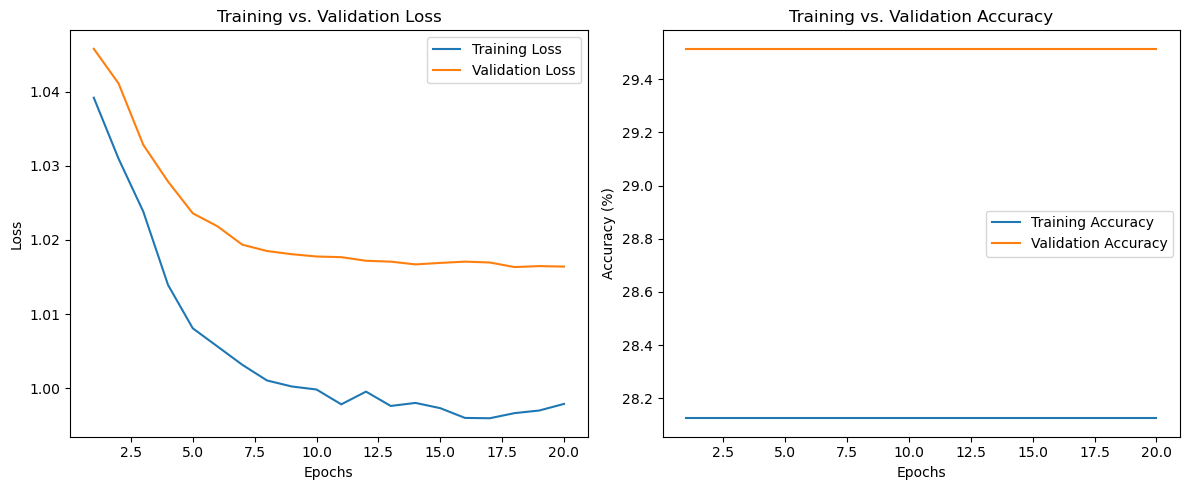

In [25]:
plot_training_results(cnn_lstm_results)

In [ ]:
plot_training_results(cnn_3d_results)

### Save and Load Model

In [26]:
def save_model(model, filepath):
    """
    Save the PyTorch model to the specified file path.

    Args:
    - model (torch.nn.Module): The model to save.
    - filepath (str): The file path where the model will be saved.
    """
    # Save the model's state dictionary (weights)
    torch.save(model.state_dict(), filepath)
    print(f"Model saved to {filepath}")

In [27]:
def load_model(model_class, filepath, device="cpu", model_args=None):
    """
    Load a PyTorch model from the specified file path.

    Args:
    - model_class (torch.nn.Module): The class of the model to load.
    - filepath (str): The file path from which to load the model.
    - device (str): The device on which to load the model ("cpu" or "cuda").
    - model_args (dict, optional): Arguments to pass to the model class constructor.

    Returns:
    - model (torch.nn.Module): The loaded model with the saved weights.
    """
    if model_args is None:
        model_args = dict()  # Safely create a new dictionary here

    # Initialize the model with additional arguments
    model = model_class(**model_args)

    # Load the model weights into the initialized model
    model.load_state_dict(torch.load(filepath, map_location=device, weights_only=True))
    model.to(device)  # Move the model to the desired device
    model.eval()  # Set the model to evaluation mode
    
    print(f"Model loaded from {filepath}")
    
    return model

In [28]:
save_model(cnn_lstm_model, "./model/cnn_lstm_model.pth")
cnn_lstm_loaded_model = load_model(EnsembleEchoCardiogramModel, "./model/cnn_lstm_model.pth", device = device, model_args={"num_classes": 12})

Model saved to ./model/cnn_lstm_model.pth
Model loaded from ./model/cnn_lstm_model.pth


In [ ]:
save_model(model_3d_cnn, "./model/3d_cnn_model.pth")
cnn_3d_loaded_model = load_model(Ensemble3DEchoCardiogramModel, "./model/3d_cnn_model.pth", device = device, model_args={"num_classes": 12})

### Confusion Matrix

In [29]:
def plot_confusion_matrix_and_roc_auc(model, dataloader, labels_a2c, labels_a4c, model_name, device='cpu', normalize=False, threshold=0.5):
    """
    Computes and plots confusion matrices and ROC AUC curves for a multilabel classification model
    in a 4x3 subplot layout, compatible with the train_model_multilabel function.

    Parameters:
        model (torch.nn.Module): The trained model.
        dataloader (torch.utils.data.DataLoader): The dataloader containing the test data.
        labels_a2c (list): List of class labels for a2c view.
        labels_a4c (list): List of class labels for a4c view.
        model_name (str): Name of the model to display in the titles.
        device (str): The device to use ('cpu' or 'cuda').
        normalize (bool): If True, normalize each confusion matrix by dividing each row by the sum of that row.
        threshold (float): Threshold for converting probabilities to binary predictions (default: 0.5).
    """
    model.eval()  # Set the model to evaluation mode
    y_true = []
    y_pred = []
    y_probs = []  # Store probabilities for ROC AUC

    with torch.no_grad():
        for batch in dataloader:
            *inputs, labels_a2c_batch, labels_a4c_batch = batch
            inputs = [x.to(device) for x in inputs]
            labels_a2c_batch = labels_a2c_batch.to(device).view(labels_a2c_batch.size(0), -1)
            labels_a4c_batch = labels_a4c_batch.to(device).view(labels_a4c_batch.size(0), -1)
            labels = torch.cat([labels_a2c_batch, labels_a4c_batch], dim=1).float()

            outputs = model(*inputs)
            probs = torch.sigmoid(outputs)  # Sigmoid to get probabilities
            predicted = (probs > threshold).float()  # Binary predictions using threshold

            y_probs.extend(probs.cpu().numpy())
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    # Convert lists to numpy arrays
    y_true = np.array(y_true)  # Shape: (n_samples, n_classes)
    y_pred = np.array(y_pred)  # Shape: (n_samples, n_classes)
    y_probs = np.array(y_probs)  # Shape: (n_samples, n_classes)

    # Combine label names
    labels = labels_a2c + labels_a4c
    n_classes = len(labels)

    # Create 4x3 subplot grid
    fig, axes = plt.subplots(4, 3, figsize=(12, 16))  # 4 rows, 3 columns
    axes = axes.flatten()  # Flatten for easier indexing

    # Plot confusion matrices
    for i in range(min(n_classes, 11)):  # Limit to 11 subplots to reserve space for ROC
        cm = confusion_matrix(y_true[:, i], y_pred[:, i], labels=[0, 1])
        
        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normalize by row
            cm = np.nan_to_num(cm)  # Replace NaN with 0 for zero rows

        sns.heatmap(cm, annot=True, fmt='.2f' if normalize else 'd', cmap='Blues',
                    xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'],
                    cbar=False, ax=axes[i], annot_kws={"size": 10})
        axes[i].set_title(f'CM: {labels[i]}', fontsize=10)
        axes[i].set_xlabel('Predicted', fontsize=8)
        axes[i].set_ylabel('True', fontsize=8)

    # Clear unused subplots (if n_classes < 11)
    for i in range(n_classes, 11):
        axes[i].axis('off')

    # Merge last row (indices 9, 10, 11) for ROC plot
    for i in range(9, 12):
        axes[i].remove()  # Remove individual subplots
    gs = axes[9].get_gridspec()
    roc_ax = fig.add_subplot(gs[3, :])  # Merge last row into one subplot

    # Plot ROC AUC curves
    fpr = {}
    tpr = {}
    roc_auc = {}
    colors = plt.cm.tab10(np.linspace(0, 1, n_classes))  # Distinct colors for each label
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        roc_ax.plot(fpr[i], tpr[i], label=f'{labels[i]} (AUC = {roc_auc[i]:.2f})', color=colors[i])

    # Compute micro-average ROC curve
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_probs.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    roc_ax.plot(fpr["micro"], tpr["micro"], label=f'Micro-average (AUC = {roc_auc["micro"]:.2f})', 
                linestyle='--', color='black')

    roc_ax.plot([0, 1], [0, 1], 'k--', lw=1)  # Diagonal line
    roc_ax.set_xlim([0.0, 1.0])
    roc_ax.set_ylim([0.0, 1.05])
    roc_ax.set_title(f'ROC AUC Curves ({model_name})', fontsize=10)
    roc_ax.set_xlabel('False Positive Rate', fontsize=8)
    roc_ax.set_ylabel('True Positive Rate', fontsize=8)
    roc_ax.legend(loc='lower right', fontsize=8)

    plt.tight_layout()
    plt.show()

    # Return metrics for further analysis
    return {
        'confusion_matrices': [confusion_matrix(y_true[:, i], y_pred[:, i], labels=[0, 1]) for i in range(n_classes)],
        'roc_auc': roc_auc,
        'labels': labels
    }

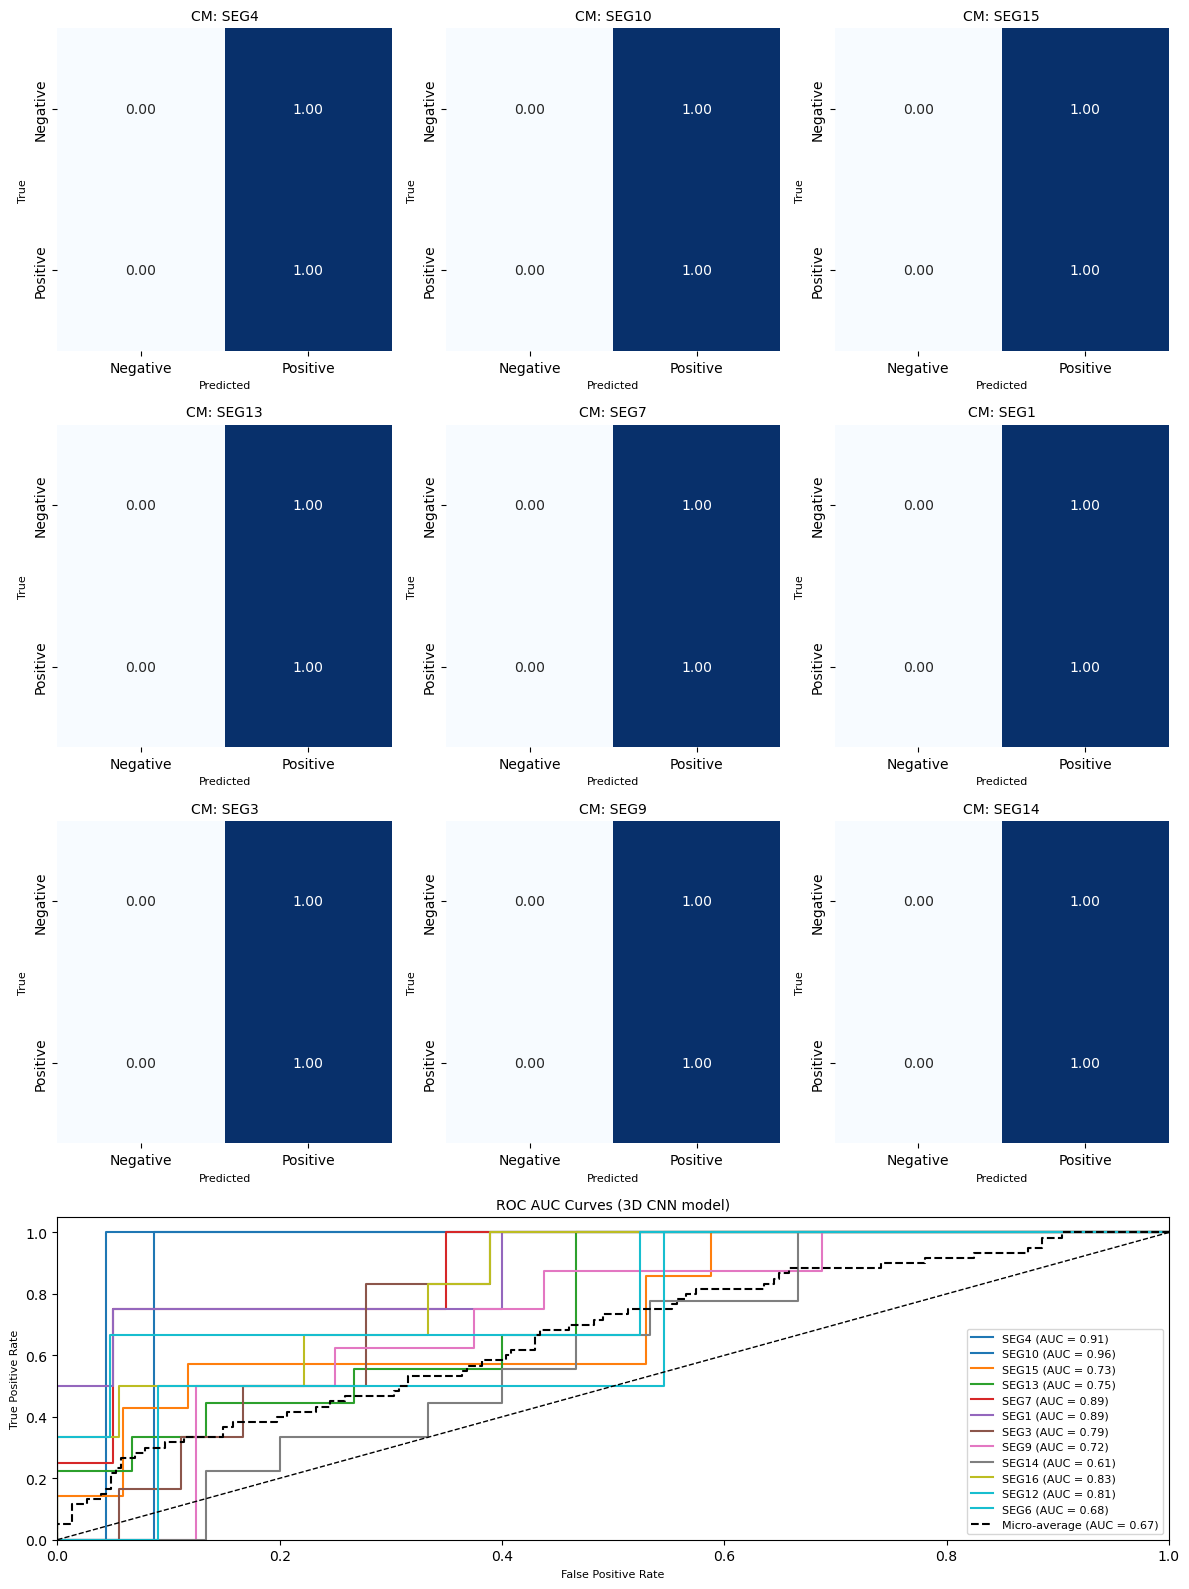

In [30]:
# Plot confusion matrices and ROC curves
labels_a2c = ['SEG4', 'SEG10', 'SEG15', 'SEG13', 'SEG7', 'SEG1']
labels_a4c = ['SEG3', 'SEG9', 'SEG14', 'SEG16', 'SEG12', 'SEG6']
metrics = plot_confusion_matrix_and_roc_auc(
    model=cnn_lstm_loaded_model,
    dataloader=test_loader,
    labels_a2c=labels_a2c,
    labels_a4c=labels_a4c,
    model_name='3D CNN model',
    device=device,
    normalize=True,
    threshold=0.5
)

In [31]:
# Print returned metrics
print("Confusion Matrices:", metrics['confusion_matrices'])
print("ROC AUC Scores:", metrics['roc_auc'])
print("Labels:", metrics['labels'])

Confusion Matrices: [array([[ 0, 23],
       [ 0,  1]], dtype=int64), array([[ 0, 23],
       [ 0,  1]], dtype=int64), array([[ 0, 17],
       [ 0,  7]], dtype=int64), array([[ 0, 15],
       [ 0,  9]], dtype=int64), array([[ 0, 20],
       [ 0,  4]], dtype=int64), array([[ 0, 20],
       [ 0,  4]], dtype=int64), array([[ 0, 18],
       [ 0,  6]], dtype=int64), array([[ 0, 16],
       [ 0,  8]], dtype=int64), array([[ 0, 15],
       [ 0,  9]], dtype=int64), array([[ 0, 18],
       [ 0,  6]], dtype=int64), array([[ 0, 21],
       [ 0,  3]], dtype=int64), array([[ 0, 22],
       [ 0,  2]], dtype=int64)]
ROC AUC Scores: {0: 0.9130434782608696, 1: 0.9565217391304348, 2: 0.7310924369747899, 3: 0.7481481481481481, 4: 0.8875, 5: 0.8875, 6: 0.7870370370370371, 7: 0.71875, 8: 0.6074074074074074, 9: 0.8333333333333334, 10: 0.8095238095238095, 11: 0.6818181818181819, 'micro': 0.6666666666666667}
Labels: ['SEG4', 'SEG10', 'SEG15', 'SEG13', 'SEG7', 'SEG1', 'SEG3', 'SEG9', 'SEG14', 'SEG16', 'SEG12',